In [1]:
import datasets
from datasets import Dataset, DatasetDict

from torchvision.transforms import ToTensor, Normalize, Compose, Resize

In [ ]:
NUM_CLIENTS = 100
NUM_LABELS = 10

DEPLOYMENT_DATASET = "cifar10"
DEPLOYMENT_DATA_SAVE_PATH = "rework/deployment_data"

In [ ]:
# load dataset
try:
    dataset = datasets.load_from_disk(DEPLOYMENT_DATA_SAVE_PATH, keep_in_memory=False)
    print("Dataset found and loaded.")
except FileNotFoundError:
    print("Dataset not found, downloading...")
    dataset = datasets.load_dataset(path=DEPLOYMENT_DATASET, keep_in_memory=False)
    dataset.save_to_disk(DEPLOYMENT_DATA_SAVE_PATH)

In [8]:
from noniid.dataset.cifar10_noniid import get_dataset_cifar10_extr_noniid

num_users_cifar = 100
nclass_cifar = 2
nsamples_cifar = 20
rate_unbalance_cifar = 0.5


train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar = get_dataset_cifar10_extr_noniid(num_users_cifar, nclass_cifar, nsamples_cifar, rate_unbalance_cifar)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
for user, group in user_groups_train_cifar.items():
    print(f"User {user} has {len(group)} samples.")

User 0 has 30 samples.
User 1 has 30 samples.
User 2 has 30 samples.
User 3 has 30 samples.
User 4 has 30 samples.
User 5 has 30 samples.
User 6 has 30 samples.
User 7 has 30 samples.
User 8 has 30 samples.
User 9 has 30 samples.
User 10 has 30 samples.
User 11 has 30 samples.
User 12 has 30 samples.
User 13 has 30 samples.
User 14 has 30 samples.
User 15 has 30 samples.
User 16 has 30 samples.
User 17 has 30 samples.
User 18 has 30 samples.
User 19 has 30 samples.
User 20 has 30 samples.
User 21 has 30 samples.
User 22 has 30 samples.
User 23 has 30 samples.
User 24 has 30 samples.
User 25 has 30 samples.
User 26 has 30 samples.
User 27 has 30 samples.
User 28 has 30 samples.
User 29 has 30 samples.
User 30 has 30 samples.
User 31 has 30 samples.
User 32 has 30 samples.
User 33 has 30 samples.
User 34 has 30 samples.
User 35 has 30 samples.
User 36 has 30 samples.
User 37 has 30 samples.
User 38 has 30 samples.
User 39 has 30 samples.
User 40 has 30 samples.
User 41 has 30 samples.
Us

In [14]:
from niid_bench.niid_bench.dataset import load_datasets

train_datasets, test_datasets, valid_set, datasets = load_datasets({
    "partitioning": "dirichlet",
    "similarity": 0.01,
    "name": "mnist",
    "alpha": 1,
    "batch_size": 32,
}, 100)

Dataset partitioning config: {'partitioning': 'dirichlet', 'similarity': 0.01, 'name': 'mnist', 'alpha': 1, 'batch_size': 32}
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 7535837.21it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 307192.15it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2934028.05it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2148475.11it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [15]:
print(sum([len(dataset) for dataset in datasets]))
for dataset in datasets:
    print(len(dataset))

60000
657
604
621
644
644
529
710
628
676
593
608
616
612
624
775
560
611
229
711
535
463
876
610
518
623
637
739
443
473
495
656
860
577
509
610
391
627
555
628
447
608
618
738
505
619
704
634
717
560
630
429
776
649
564
758
611
665
261
502
438
602
861
736
607
595
596
617
726
534
633
605
714
518
443
862
351
649
531
500
586
784
518
625
660
615
558
678
598
750
694
671
612
477
325
660
633
641
433
285
607


(array([ 1.,  1.,  3.,  2.,  2.,  7.,  9.,  9., 15., 25.,  8.,  7.,  4.,
         2.,  2.,  1.,  1.,  0.,  0.,  1.]),
 array([176.  , 212.95, 249.9 , 286.85, 323.8 , 360.75, 397.7 , 434.65,
        471.6 , 508.55, 545.5 , 582.45, 619.4 , 656.35, 693.3 , 730.25,
        767.2 , 804.15, 841.1 , 878.05, 915.  ]),
 <BarContainer object of 20 artists>)

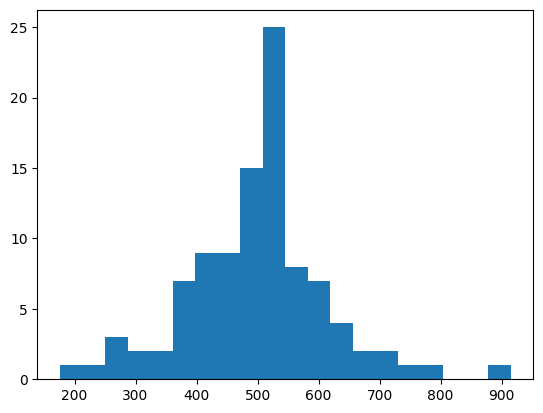

In [12]:
import matplotlib.pyplot as plt

plt.hist([len(dataset) for dataset in datasets], bins=20)